In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.linear_model import ElasticNet

# train_test_valid

In [3]:
df_all = pd.read_csv('df_clear_new_wo_out.csv', index_col = ['Id'])
df_sample = pd.read_csv('sample_submission.csv')

In [4]:
df_train = df_all[df_all['train_test']=='train']
df_test = df_all[df_all['train_test']=='test']
#target = df_train['SalePrice']
target = np.log(df_train['SalePrice'])
df_train = df_train.drop(['train_test', 'SalePrice'], axis = 1).copy()
df_test = df_test.drop(['train_test', 'SalePrice'], axis = 1).copy()


In [5]:
df_train.iloc[:,218].value_counts()

0.0    1418
1.0      12
Name: Functional_Maj1, dtype: int64

In [6]:
df_test.iloc[:,218].value_counts()

0.0    1454
1.0       5
Name: Functional_Maj1, dtype: int64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

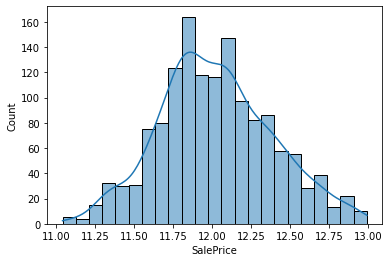

In [7]:
sns.histplot(target, kde = True)

In [8]:
x, y = df_train.to_numpy(), target.to_numpy()

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=.3, random_state=1)
x_train.shape,  x_valid.shape, y_train.shape, y_valid.shape

#Normalizaton
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_valid_norm = scaler.transform(x_valid)

In [10]:
#sns.histplot(pd.DataFrame(x_train_norm), kde = True)

In [11]:
x_train.shape,  x_valid.shape, y_train.shape, y_valid.shape
df_train.shape

(1430, 270)

x_train, x_valid, y_train, y_valid = train_valid_split(x, y, test_size=.3, random_state=1)
x_train.shape,  x_valid.shape, y_train.shape, y_valid.shape

from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
x_train_norm = scaler.fit_transform(x_train)
x_valid_norm = scaler.transform(x_valid)

# GBR

In [19]:
GBR = GradientBoostingRegressor()

# будут рассмотрены все возможные комбинаци этих значений
param_grid = {
    'loss': ['ls', 'lad','huber'],
    'learning_rate': [0.02, 0.05, 0.06],
    'n_estimators': [500, 1000],
    'max_depth': [3,4],
    'max_leaf_nodes': [25],
    'max_features': ['log2', 'sqrt'],
    'tol': [0.005, 0.003],
    'min_samples_leaf': [1, 5, 8],
    'min_samples_split': [2, 4, 6]
}

# создаем объект
cv = GridSearchCV(
    estimator=GBR,
    param_grid=param_grid,
    scoring=make_scorer(lambda t,p: mean_squared_error(t,p)**.5, greater_is_better=False),
    return_train_score=True,
    #refit=True,
    cv=5, # количество фолдов
    verbose=4, # сколько печатать сообщений
    n_jobs=-1, # насколько параллелельно считаем
)

In [20]:
cv.fit(x_train_norm, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05, 0.06],
                         'loss': ['ls', 'lad', 'huber'], 'max_depth': [3, 4],
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [25], 'min_samples_leaf': [1, 5, 8],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [500, 1000], 'tol': [0.005, 0.003]},
             return_train_score=True,
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=4)

In [21]:
cv.best_params_, cv.best_score_

({'learning_rate': 0.05,
  'loss': 'huber',
  'max_depth': 4,
  'max_features': 'log2',
  'max_leaf_nodes': 25,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 1000,
  'tol': 0.005},
 -0.11714954949386328)

In [26]:
pd.DataFrame(cv.cv_results_)[['mean_train_score', 'mean_test_score', 'params']].sort_values('mean_test_score', ascending = False)

,mean_train_score,mean_test_score,params
802,-0.043910,-0.117150,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
402,-0.055619,-0.117804,"{'learning_rate': 0.02, 'loss': 'huber', 'max_..."
362,-0.060348,-0.118353,"{'learning_rate': 0.02, 'loss': 'huber', 'max_..."
761,-0.068036,-0.118474,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
1214,-0.063855,-0.118490,"{'learning_rate': 0.06, 'loss': 'huber', 'max_..."
...,...,...,...
169,-0.116419,-0.134204,"{'learning_rate': 0.02, 'loss': 'lad', 'max_de..."
160,-0.115678,-0.134316,"{'learning_rate': 0.02, 'loss': 'lad', 'max_de..."
173,-0.117089,-0.134322,"{'learning_rate': 0.02, 'loss': 'lad', 'max_de..."
156,-0.115269,-0.134745,"{'learning_rate': 0.02, 'loss': 'lad', 'max_de..."


In [367]:
cv.best_estimator_, cv.best_estimator_.predict

(GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                           n_estimators=500, tol=0.001),
 <bound method GradientBoostingRegressor.predict of GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                           n_estimators=500, tol=0.001)>)

In [368]:
cv.best_estimator_.fit(x_train_norm,y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                          n_estimators=500, tol=0.001)

In [27]:
gb = GradientBoostingRegressor(**cv.best_params_)
gb.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='log2', max_leaf_nodes=25,
                          min_samples_split=6, n_estimators=1000, tol=0.005)

In [28]:
gb.predict(x_train)

array([12.01684326, 12.19047016, 11.63580311, ..., 11.77199693,
       12.62570038, 11.9515796 ])

In [370]:
cv.predict(x_train)

array([12.36001096, 12.5096602 , 12.36496999, ..., 12.4766185 ,
       12.50140669, 12.34773576])

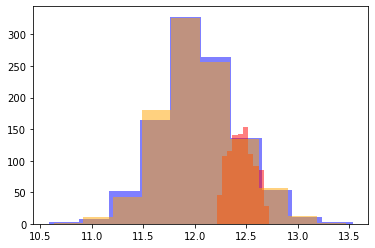

In [371]:
plt.hist(y_train, alpha=0.5, color='b')
plt.hist(cv.predict(x_train), alpha=0.5, color='r');
plt.hist(gb.predict(x_train), alpha=0.5, color='orange');

In [373]:
print(f'''
    Score:
    train {mean_squared_error(y_train, cv.predict(x_train_norm))**.5 :.2f}
    test {mean_squared_error(y_valid, cv.predict(x_valid_norm))**.5 :.2f}
''')
#np.e**elastic_net.predict(test)})


    Score:
    train 0.07
    test 0.15



In [333]:
# исследуем результаты в DataFrame
res = pd.DataFrame(cv.cv_results_)
print(res.shape)
res.head()

(96, 26)


NameError: name 'df' is not defined

In [184]:
# выделим только нужные колонки
res1[[x for x in res1 if 'param_' in x] + ['mean_test_score', 'std_test_score']].sort_values('mean_test_score').tail(5)

,param_learning_rate,param_loss,param_max_depth,param_max_features,param_max_leaf_nodes,param_n_estimators,param_tol,mean_test_score,std_test_score
112,0.1,huber,3,sqrt,25,500,0.0005,-0.127672,0.009031
23,0.1,ls,3,sqrt,None,500,0.001,-0.127647,0.011265
70,0.1,lad,3,sqrt,None,500,0.0005,-0.127235,0.013972
116,0.1,huber,3,sqrt,None,200,0.0005,-0.126905,0.010244
118,0.1,huber,3,sqrt,None,500,0.0005,-0.126100,0.011707


# Kaggle

In [29]:
x_test_kag = df_test.to_numpy()
x_test_norm = scaler.transform(x_test_kag)

In [30]:
x_test_kag.shape

(1459, 270)

In [31]:
np.e**cv.best_estimator_.predict(x_test_norm)

array([126077.87643435, 154031.87447271, 184788.51071458, ...,
       152703.11546466, 116504.27822386, 211133.29285555])

In [32]:
df_sample['SalePrice'] = np.e**cv.best_estimator_.predict(x_test_norm)

In [33]:
df_sample.to_csv('house_prices_kag_boost2_wo_out.csv',columns = ['Id','SalePrice'],index=False)

# Mark

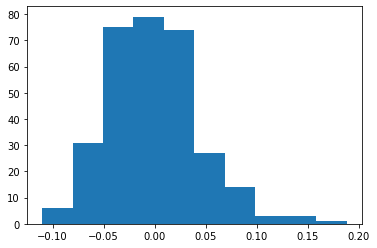

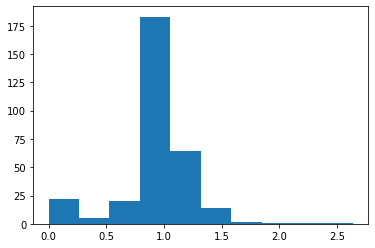

In [269]:
plt.hist(x_test_norm.mean(axis=0));
plt.show()
plt.hist(x_test_norm.std(axis=0));

In [314]:
x_test_norm.std(axis=0)[218]

0.7268579582620178

# KNN

In [323]:
# Grid search + cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
# создаем объект, не задавая параметры. Можно задать параметры, которые не будет изменяться при GS
KNR = KNeighborsRegressor( )

# будут рассмотрены все возможные комбинаци этих значений
param_grid = {
    'n_neighbors': [3,5,7],
    'p': [1,2,3],
    'weights': ['uniform', 'distance'],
    'leaf_size':[9, 10] 
}

# создаем объект
cv_knn = GridSearchCV(
    estimator = KNR, 
    param_grid = param_grid,
    scoring = make_scorer(lambda t,p: mean_squared_log_error(t,p)**.5, greater_is_better=False), # метрика, которую будем *максимизировать*
    return_train_score= True,
    cv=5, #кол-во фолдов
    verbose = 4,
    n_jobs = -1, # насколько параллелельно считаем,
    refit=True
    )

In [324]:
cv_knn.fit(x_train_norm, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [9, 10], 'n_neighbors': [3, 5, 7],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
             return_train_score=True,
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=4)

In [325]:
cv_knn.best_params_, cv_knn.best_score_

({'leaf_size': 9, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'},
 -0.013865228118902364)

In [326]:
cv_knn.best_estimator_, cv_knn.best_estimator_.predict

(KNeighborsRegressor(leaf_size=9, p=1, weights='distance'),
 <bound method KNeighborsRegressor.predict of KNeighborsRegressor(leaf_size=9, p=1, weights='distance')>)

In [328]:
#cv_knn.fit(x_train_norm,y_train)

In [331]:
print(f'''
    Score:
    train {mean_squared_error(y_train, cv_knn.predict(x_train_norm))**.5 :.2f}
    test {mean_squared_error(y_valid, cv_knn.predict(x_valid_norm))**.5 :.2f}  
''')


    Score:
    train 0.00
    test 0.21  

